# CSE 574 Introduction to Machine Learning Fall 2019 Project 2
# Neural Network based Classification of Fashion Clothing Images
## Srisai Karthik Neelamraju, neelamra@buffalo.edu

### Importing the required libraries

In [1]:
import numpy as np
from sklearn import preprocessing, metrics
import matplotlib.pyplot as plt
import util_mnist_reader
import keras
# %load_ext tensorboard

Using TensorFlow backend.


### Helper Functions

In [2]:
# function to calculate logistic sigmoid
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# function to calculate softmax
def softmax(z):
    exp = np.exp(z)
    return exp / np.sum(exp, axis=0, keepdims=True)

# function to calculate accuracy
def get_accuracy(Y_expected, Y_pred):
    return metrics.accuracy_score(Y_expected, Y_pred)

# function to calculate confusion matrix
def get_confusion_matrix(Y_expected, Y_pred):
    return metrics.confusion_matrix(Y_expected, Y_pred)

# function to split training data into mini batches
# concept from https://www.geeksforgeeks.org/ml-mini-batch-gradient-descent-with-python/
def split_into_minibatches(X_train, Y_train, minibatch_size):
    n_features = X_train.shape[0]
    n_train = X_train.shape[1]
    n_minibatch = n_train // minibatch_size
    stacked_data = np.vstack((X_train, Y_train))
    np.random.shuffle(stacked_data.T)
    minibatches = []
    for i in range(n_minibatch):
        start = i * minibatch_size
        end = (i + 1) * minibatch_size
        minibatch = stacked_data[:, start:end]
        X_minibatch = minibatch[:n_features, :]
        Y_minibatch = minibatch[n_features:, :]
        minibatches.append((X_minibatch, Y_minibatch))
    if n_train % minibatch_size == 0:
        return minibatches
    start = n_minibatch * minibatch_size
    end = n_train
    minibatch = stacked_data[:, start:end]
    X_minibatch = minibatch[:n_features, :]
    Y_minibatch = minibatch[n_features:, :]
    minibatches.append((X_minibatch, Y_minibatch))
    return minibatches

### Reading the Fashion MNIST dataset

In [3]:
# training data
X_train, Y_train = util_mnist_reader.load_mnist('data/fashion', kind='train')

# test data
X_test, Y_test = util_mnist_reader.load_mnist('data/fashion', kind='t10k')

### Reshaping the testing data

In [4]:
# reshaping Y_train and Y_test to get rid of rank 1 Python arrays
Y_train = np.array(Y_train).reshape(Y_train.shape[0], 1)
Y_test = np.array(Y_test).reshape(Y_test.shape[0], 1)

## Task 1: Implementing single layer Fully Connected Neural Network

### Preprocessing the dataset

In [5]:
# flattening the 28 x 28 input images
X_train_nn = X_train.reshape(X_train.shape[0], 784)
X_test_nn = X_test.reshape(X_test.shape[0], 784)

# standard scaling of the features
X_train_nn = preprocessing.scale(X_train_nn)
X_test_nn = preprocessing.scale(X_test_nn)

# reshaping X_train_nn and X_test_nn such that features are along the rows and instances are along the columns
X_train_nn = X_train_nn.T
X_test_nn = X_test_nn.T

### One-hot encoding the output labels

In [6]:
one_hot = preprocessing.OneHotEncoder(categories=[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]], sparse=False)
Y_train_nn = one_hot.fit_transform(Y_train)
Y_test_nn = one_hot.fit_transform(Y_test)

# reshaping Y_train_nn and Y_test_nn such that instances are along the columns
Y_train_nn = Y_train_nn.T
Y_test_nn = Y_test_nn.T

### Defining hyperparameters for training the network

In [7]:
# number of units in the hidden and the output layers
n_hidden = 128
n_out = 10

# number of epochs for training
epochs = 50

# mini-batch size
minibatch_size = 32

# learning rate for gradient descent
lr_nn = 0.03

### Initializing weights and biases

In [8]:
W1 = np.random.randn(n_hidden, X_train_nn.shape[0])
b1 = np.zeros([n_hidden, 1])
W2 = np.random.randn(n_out, n_hidden)
b2 = np.zeros([n_out, 1])

### Training the single layer neural network

In [9]:
# number of training and testing examples
n_train = X_train_nn.shape[1]
n_test = X_test_nn.shape[1]
                
# lists to keep track of training and validation losses
loss_train = []
loss_val = []

# lists to keep track of training and validation accuracies
accuracy_train = []
accuracy_val = []

# implementing the algorithm for "epochs" number of iterations over the training set
for epoch in range(1, epochs + 1):
    
    # intializing the training loss to zero at the beginning of each epoch
    epoch_loss_train = 0
    
    # splitting the training set into mini-batches
    minibatches = split_into_minibatches(X_train_nn, Y_train_nn, minibatch_size)
    
    for minibatch in minibatches:
        
        # input features and outputs for each mini-batch
        X_minibatch = minibatch[0]
        Y_minibatch = minibatch[1]

        # first layer of neural network
        Z1 = np.dot(W1, X_minibatch) + b1
        A1 = sigmoid(Z1)

        # second layer of neural network
        Z2 = np.dot(W2, A1) + b2
        A2 = softmax(Z2)

        # loss function
        epoch_loss_train += - np.sum(np.multiply(Y_minibatch, np.log(A2)))

        # backward propagation
        dZ2 = A2 - Y_minibatch
        dW2 = (1/minibatch_size) * np.dot(dZ2, A1.T)
        db2 = (1/minibatch_size) * np.sum(dZ2, axis = 1, keepdims=True)
        dA1 = np.dot(W2.T, dZ2)
        dZ1 = np.multiply(dA1, (1 - np.power(A1, 2)))
        dW1 = (1/minibatch_size) * np.dot(dZ1, X_minibatch.T)
        db1 = (1/minibatch_size) * np.sum(dZ1, axis = 1, keepdims=True)

        # gradient descent
        W2 = W2 - lr_nn * dW2
        b2 = b2 - lr_nn * db2
        W1 = W1 - lr_nn * dW1
        b1 = b1 - lr_nn * db1
        
    # training loss after each epoch
    epoch_loss_train = (1/n_train) * epoch_loss_train
    loss_train.append(epoch_loss_train)
    
    # training accuracy after each epoch
    Y_pred_train = softmax(np.dot(W2, sigmoid(np.dot(W1, X_train_nn) + b1)) + b2)
    Y_pred_train = Y_pred_train.argmax(axis=0).reshape([1, n_train])
    Y_act_train = Y_train_nn.argmax(axis=0).reshape([1, n_train])
    acc_train = get_accuracy(Y_act_train[0], Y_pred_train[0])
    accuracy_train.append(acc_train)
    
    # validation loss after each epoch
    Y_pred_val = softmax(np.dot(W2, sigmoid(np.dot(W1, X_test_nn) + b1)) + b2)
    epoch_loss_val = (-1/n_test) * np.sum(np.multiply(Y_test_nn, np.log(Y_pred_val)))
    loss_val.append(epoch_loss_val)
    
    # validation accuracy after each epoch
    Y_pred_val = Y_pred_val.argmax(axis=0).reshape([1, n_test])
    Y_act_val = Y_test_nn.argmax(axis=0).reshape([1, n_test])
    acc_val = get_accuracy(Y_act_val[0], Y_pred_val[0])
    accuracy_val.append(acc_val)
    
    print("Epoch " + str(epoch) + "/" + str(epochs) + " - loss: " + "{:.4f}".format(epoch_loss_train) + " - acc: " + "{:.4f}".format(acc_train) + " - val_loss: " + "{:.4f}".format(epoch_loss_val) + " - val_acc: " + "{:.4f}".format(acc_val))

Epoch 1/50 - loss: 1.2077 - acc: 0.7866 - val_loss: 0.8940 - val_acc: 0.7771
Epoch 2/50 - loss: 0.7738 - acc: 0.8110 - val_loss: 0.7610 - val_acc: 0.7961
Epoch 3/50 - loss: 0.6566 - acc: 0.8239 - val_loss: 0.6913 - val_acc: 0.8094
Epoch 4/50 - loss: 0.5940 - acc: 0.8300 - val_loss: 0.6560 - val_acc: 0.8137
Epoch 5/50 - loss: 0.5472 - acc: 0.8386 - val_loss: 0.6244 - val_acc: 0.8203
Epoch 6/50 - loss: 0.5179 - acc: 0.8443 - val_loss: 0.5945 - val_acc: 0.8221
Epoch 7/50 - loss: 0.4922 - acc: 0.8472 - val_loss: 0.5835 - val_acc: 0.8242
Epoch 8/50 - loss: 0.4742 - acc: 0.8480 - val_loss: 0.5740 - val_acc: 0.8232
Epoch 9/50 - loss: 0.4594 - acc: 0.8508 - val_loss: 0.5607 - val_acc: 0.8269
Epoch 10/50 - loss: 0.4492 - acc: 0.8528 - val_loss: 0.5440 - val_acc: 0.8297
Epoch 11/50 - loss: 0.4396 - acc: 0.8539 - val_loss: 0.5306 - val_acc: 0.8340
Epoch 12/50 - loss: 0.4318 - acc: 0.8558 - val_loss: 0.5253 - val_acc: 0.8351
Epoch 13/50 - loss: 0.4259 - acc: 0.8597 - val_loss: 0.5198 - val_acc: 0.

### Comparing loss for training and validation sets

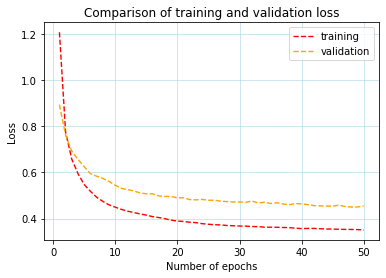

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [10]:
plt.plot(range(1, epochs + 1), loss_train, color='red', linestyle='dashed', linewidth=1.4, label='training')
plt.plot(range(1, epochs + 1), loss_val, color='orange', linestyle='dashed', linewidth=1.4, label='validation')
plt.grid(color='#ADD8E6', linestyle='-', linewidth=0.6)
plt.title('Comparison of training and validation loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.savefig('nn_train_vs_val_loss.jpg', format='jpg', dpi=1000)
plt.show()
plt.figure()

### Comparing accuracy for training and validation sets

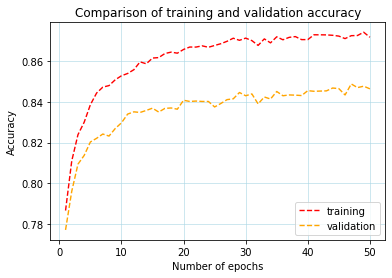

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [11]:
plt.plot(range(1, epochs + 1), accuracy_train, color='red', linestyle='dashed', linewidth=1.4, label='training')
plt.plot(range(1, epochs + 1), accuracy_val, color='orange', linestyle='dashed', linewidth=1.4, label='validation')
plt.grid(color='#ADD8E6', linestyle='-', linewidth=0.6)
plt.title('Comparison of training and validation accuracy')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.savefig('nn_train_vs_val_accuracy.jpg', format='jpg', dpi=1000)
plt.show()
plt.figure()

### Predicting output labels for test data

In [12]:
Y_pred_nn = softmax(np.dot(W2, sigmoid(np.dot(W1, X_test_nn) + b1)) + b2)
Y_pred_nn = Y_pred_nn.argmax(axis=0)

# reshaping Y_pred_nn to get rid of rank 1 Python arrays
Y_pred_nn = Y_pred_nn.reshape(Y_pred_nn.shape[0], 1)

### Evaluating the single layer NN model

In [13]:
print("ANALYSIS FOR SINGLE LAYER FULLY CONNECTED NEURAL NETWORK\n")

print("Accuracy on the test set -", get_accuracy(Y_test, Y_pred_nn), "\n")
print("Confusion Matrix for performance on the test set -\n", get_confusion_matrix(Y_test, Y_pred_nn))

ANALYSIS FOR SINGLE LAYER FULLY CONNECTED NEURAL NETWORK

Accuracy on the test set - 0.8464 

Confusion Matrix for performance on the test set -
 [[851   3  21  38   4   0  75   0   8   0]
 [  2 964   1  22   7   0   4   0   0   0]
 [ 25   3 693  12 197   3  59   0   8   0]
 [ 35  13  14 864  44   1  23   0   6   0]
 [  1   1  72  28 836   0  55   0   6   1]
 [  1   0   0   1   0 915   0  51   4  28]
 [187   5 102  28 145   3 514   0  16   0]
 [  0   0   0   0   0  29   0 937   2  32]
 [  4   0   8   5   6   8   9   6 953   1]
 [  0   0   0   1   0  19   1  40   2 937]]


## Task 2: Implementing multi-layer Fully Connected Neural Network using Keras

### Preprocessing the dataset

In [14]:
# minmax scaling of the features to the range [0, 1]
X_train_dnn = X_train / 255.0
X_test_dnn = X_test / 255.0

### Defining hyperparameters for training the network

In [15]:
# number of epochs for training
epochs_dnn = 15

# mini-batch size
minibatch_size_dnn = 256

# learning rate of the optimizer
lr_dnn = 0.0001

### Defining the multi-layer neural network architecture

In [16]:
dnn = keras.Sequential()

dnn.add(keras.layers.Flatten(input_shape = (28, 28)))
dnn.add(keras.layers.Dense(512, activation='relu'))
dnn.add(keras.layers.Dense(256, activation='relu'))
dnn.add(keras.layers.Dense(128, activation='relu'))
dnn.add(keras.layers.Dense(10, activation='softmax'))

# display the neural network architecture
dnn.summary()




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1290      
Total params: 567,434
Trainable params: 567,434
Non-trainable params: 0
_________________________________________________________________


### Compiling the model

In [17]:
# defining the optimizer
optimizer = keras.optimizers.Adam(lr=lr_dnn)

dnn.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'])

# using tensorboard to visualize the model and its performance
# tensorboard_callback_dnn = keras.callbacks.TensorBoard(log_dir="tensorboard/dnn", histogram_freq=1)
# %tensorboard --logdir tensorboard/dnn

### Training the model

In [18]:
dnn_fit = dnn.fit(
    X_train_dnn,
    Y_train,
    batch_size = minibatch_size_dnn,
    epochs=epochs_dnn,
    validation_data=(X_test_dnn, Y_test))
    # callbacks=[tensorboard_callback_dnn])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 7s 124us/step - loss: 0.7975 - acc: 0.7533 - val_loss: 0.5088 - val_acc: 0.8266
Epoch 2/15
60000/60000 [==============================] - 7s 114us/step - loss: 0.4493 - acc: 0.8460 - val_loss: 0.4562 - val_acc: 0.8380
Epoch 3/15
60000/60000 [==============================] - 7s 112us/step - loss: 0.4013 - acc: 0.8598 - val_loss: 0.4137 - val_acc: 0.8541
Epoch 4/15
60000/60000 [==============================] - 7s 111us/step - loss: 0.3724 - acc: 0.8699 - val_loss: 0.4030 - val_acc: 0.8545
Epoch 5/15
60000/60000 [==============================] - 7s 110us/step - loss: 0.3531 - acc: 0.8757 - val_loss: 0.3836 - val_acc: 0.8651
Epoch 6/15
60000/60000 [==============================] - 7s 111us/step - loss: 0.3391 - acc: 0.8799 - val_loss: 0.3783 - val_acc: 0.8662
Epoch 7/15
60000/60000 [===

### Comparing loss for training and validation sets

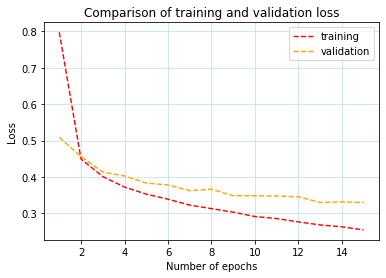

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [19]:
plt.plot(range(1, epochs_dnn + 1), dnn_fit.history['loss'], color='red', linestyle='dashed', linewidth=1.4, label='training')
plt.plot(range(1, epochs_dnn + 1), dnn_fit.history['val_loss'], color='orange', linestyle='dashed', linewidth=1.4, label='validation')
plt.grid(color='#ADD8E6', linestyle='-', linewidth=0.6)
plt.title('Comparison of training and validation loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.savefig('dnn_train_vs_val_loss.jpg', format='jpg', dpi=1000)
plt.show()
plt.figure()

### Comparing accuracy for training and validation sets

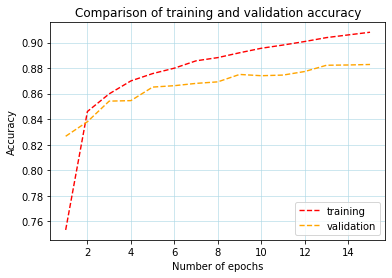

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [20]:
plt.plot(range(1, epochs_dnn + 1), dnn_fit.history['acc'], color='red', linestyle='dashed', linewidth=1.4, label='training')
plt.plot(range(1, epochs_dnn + 1), dnn_fit.history['val_acc'], color='orange', linestyle='dashed', linewidth=1.4, label='validation')
plt.grid(color='#ADD8E6', linestyle='-', linewidth=0.6)
plt.title('Comparison of training and validation accuracy')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.savefig('dnn_train_vs_val_accuracy.jpg', format='jpg', dpi=1000)
plt.show()
plt.figure()

### Predicting output labels for test data

In [21]:
Y_pred_dnn = dnn.predict(X_test_dnn).argmax(axis=1)

# reshaping Y_pred_dnn to get rid of rank 1 Python arrays
Y_pred_dnn = Y_pred_dnn.reshape(Y_pred_dnn.shape[0], 1)

### Evaluating the DNN model

In [22]:
print("ANALYSIS FOR MULTI-LAYER FULLY CONNECTED NEURAL NETWORK\n")

print("Accuracy on the test set -", get_accuracy(Y_test, Y_pred_dnn), "\n")
print("Confusion Matrix for performance on the test set -\n", get_confusion_matrix(Y_test, Y_pred_dnn))

ANALYSIS FOR MULTI-LAYER FULLY CONNECTED NEURAL NETWORK

Accuracy on the test set - 0.8828 

Confusion Matrix for performance on the test set -
 [[844   2   8  24   7   3 101   0  11   0]
 [  5 968   0  22   3   0   1   0   1   0]
 [ 19   0 725  12 156   0  85   0   3   0]
 [ 19   7   9 895  40   0  25   0   5   0]
 [  0   1  50  24 870   0  51   0   4   0]
 [  0   0   0   1   0 960   0  24   2  13]
 [130   1  61  31  76   0 685   0  16   0]
 [  0   0   0   0   0  18   0 955   0  27]
 [  8   0   1   3   5   1   4   5 973   0]
 [  0   0   0   1   0   9   1  36   0 953]]


## Task 3: Implementing Convolutional Neural Network using Keras

### Preprocessing the dataset

In [23]:
# minmax scaling of the features to the range [0, 1]
X_train_cnn = X_train / 255.0
X_test_cnn = X_test / 255.0

### Reshaping the training data to include number of channels

In [24]:
X_train_cnn = np.array(X_train_cnn).reshape(X_train.shape[0], 28, 28, 1)
X_test_cnn = np.array(X_test_cnn).reshape(X_test.shape[0], 28, 28, 1)

### Defining hyperparameters for training the network

In [25]:
# number of epochs for training
epochs_cnn = 10

# mini-batch size
minibatch_size_cnn = 64

# learning rate of the optimizer
lr_cnn = 0.001

### Defining the convolutional neural network architecture

In [26]:
cnn = keras.Sequential()

cnn.add(keras.layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding="same", input_shape=(28, 28, 1)))
cnn.add(keras.layers.Dropout(0.2))
cnn.add(keras.layers.MaxPooling2D(pool_size = 2, padding="valid"))
cnn.add(keras.layers.Conv2D(filters=32, kernel_size=3, activation="relu", padding="same"))
cnn.add(keras.layers.Dropout(0.2))
cnn.add(keras.layers.MaxPooling2D(pool_size = 2, padding="valid"))
cnn.add(keras.layers.Flatten())
cnn.add(keras.layers.Dense(256, activation='relu'))
cnn.add(keras.layers.Dense(10, activation='softmax'))

# display the neural network architecture
cnn.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 28, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        18464     
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 32)          0         
__________________________

### Compiling the model

In [27]:
# defining the optimizer
optimizer = keras.optimizers.Adam(lr=lr_cnn)

cnn.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'])

# using tensorboard to visualize the model and its performance
# tensorboard_callback_cnn = keras.callbacks.TensorBoard(log_dir="tensorboard/cnn", histogram_freq=1)
# %tensorboard --logdir tensorboard/dnn

### Training the model

In [28]:
cnn_fit = cnn.fit(
    X_train_cnn,
    Y_train,
    batch_size = minibatch_size_cnn,
    epochs=epochs_cnn,
    validation_data=(X_test_cnn, Y_test))
    # callbacks=[tensorboard_callback_cnn])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 158s 3ms/step - loss: 0.4269 - acc: 0.8463 - val_loss: 0.3453 - val_acc: 0.8823
Epoch 2/10
60000/60000 [==============================] - 155s 3ms/step - loss: 0.2860 - acc: 0.8955 - val_loss: 0.2959 - val_acc: 0.8972
Epoch 3/10
60000/60000 [==============================] - 154s 3ms/step - loss: 0.2458 - acc: 0.9102 - val_loss: 0.2732 - val_acc: 0.9062
Epoch 4/10
60000/60000 [==============================] - 151s 3ms/step - loss: 0.2184 - acc: 0.9187 - val_loss: 0.2520 - val_acc: 0.9082
Epoch 5/10
60000/60000 [==============================] - 152s 3ms/step - loss: 0.1968 - acc: 0.9267 - val_loss: 0.2252 - val_acc: 0.9168
Epoch 6/10
60000/60000 [==============================] - 152s 3ms/step - loss: 0.1782 - acc: 0.9328 - val_loss: 0.2328 - val_acc: 0.9182
Epoch 7/10
60000/60000 [==============================] - 151s 3ms/step - loss: 0.1621 - acc: 0.9398 - val_loss: 0.2304 - 

### Comparing loss for training and validation sets

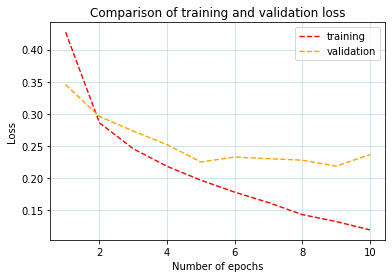

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [29]:
plt.plot(range(1, epochs_cnn + 1), cnn_fit.history['loss'], color='red', linestyle='dashed', linewidth=1.4, label='training')
plt.plot(range(1, epochs_cnn + 1), cnn_fit.history['val_loss'], color='orange', linestyle='dashed', linewidth=1.4, label='validation')
plt.grid(color='#ADD8E6', linestyle='-', linewidth=0.6)
plt.title('Comparison of training and validation loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.savefig('cnn_train_vs_val_loss.jpg', format='jpg', dpi=1000)
plt.show()
plt.figure()

### Comparing accuracy for training and validation sets

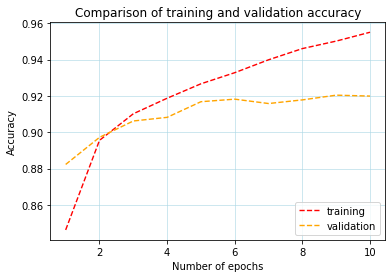

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [30]:
plt.plot(range(1, epochs_cnn + 1), cnn_fit.history['acc'], color='red', linestyle='dashed', linewidth=1.4, label='training')
plt.plot(range(1, epochs_cnn + 1), cnn_fit.history['val_acc'], color='orange', linestyle='dashed', linewidth=1.4, label='validation')
plt.grid(color='#ADD8E6', linestyle='-', linewidth=0.6)
plt.title('Comparison of training and validation accuracy')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.savefig('cnn_train_vs_val_accuracy.jpg', format='jpg', dpi=1000)
plt.show()
plt.figure()

### Predicting output labels for test data

In [31]:
Y_pred_cnn = cnn.predict(X_test_cnn).argmax(axis=1)

# reshaping Y_pred_dnn to get rid of rank 1 Python arrays
Y_pred_cnn = Y_pred_cnn.reshape(Y_pred_cnn.shape[0], 1)

### Evaluating the CNN model

In [32]:
print("ANALYSIS FOR CONVOLUTIONAL NEURAL NETWORK\n")

print("Accuracy on the test set -", get_accuracy(Y_test, Y_pred_cnn), "\n")
print("Confusion Matrix for performance on the test set -\n", get_confusion_matrix(Y_test, Y_pred_cnn))

ANALYSIS FOR CONVOLUTIONAL NEURAL NETWORK

Accuracy on the test set - 0.9199 

Confusion Matrix for performance on the test set -
 [[893   0  25  13   5   1  60   0   3   0]
 [  4 981   2   8   3   0   0   0   2   0]
 [ 19   1 906   5  45   0  24   0   0   0]
 [ 24   1  17 915  31   0  11   0   1   0]
 [  1   0  55  11 912   0  21   0   0   0]
 [  0   0   0   0   0 981   0  12   0   7]
 [128   0  70  20  95   0 681   0   6   0]
 [  0   0   0   0   0   6   0 977   0  17]
 [  5   0   2   3   1   1   0   1 987   0]
 [  1   0   0   0   0   4   0  29   0 966]]
